In [ ]:
!pip install --upgrade pip
!pip install iqm-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Using cached iqm_client-33.0.3-py3-none-any.whl.metadata (17 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached iqm_pulse-12.7.3-py3-none-any.whl.metadata (14 kB)
  Using cached iqm_station_control_client-12.0.3-py3-none-any.whl.metadata (14 kB)
  Using cached iqm_data_definitions-2.22-py3-none-any.whl.metadata (19 kB)
  Using cached python_rapidjson-1.20-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached Jinja2-3.0.3-py3-none-any.whl.metadata (3.5 kB)
  Using cached scipy-1.15.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy_stubs-1.17.0.2-py3-none-any.whl.metadata (28 kB)
  Using 

In [ ]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
iqm-station-control-client 12.0.3 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
iqm-exa-common 27.4.3 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
iqm-client 33.0.3 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
opentelemetry-resourcedetector-gcp 1.11.0a0 requires opentelemetry-api~=1.30, but you have opentelemetry-api 1.27.0 which is incompatible.
opentelemetry-resourcedetector-gcp 1.11.0a0 requires opentelemetry-sdk~=1.30, but you have opentelemetry-sdk 1.27.

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

In [ ]:
from qiskit import *

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.measure_all()

In [ ]:
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token=input("Input your IQM Resonance token"))
backend = provider.get_backend()

qc_transpiled = transpile(qc,backend)
job = backend.run(qc_transpiled)

results=job.result()
print(results.get_counts())

Input your IQM Resonance tokend05vREC9inzDMruJ0D+XQwr/s+i9N7N8yCE+WAFryuoBnBc4eXFykoHNS7vmilnS
{'000': 461, '111': 420, '010': 45, '011': 27, '101': 34, '100': 23, '110': 11, '001': 3}


In [ ]:
import numpy as np
circuits = []

num_circuits=5
phases = [2*np.pi*x/num_circuits for x in range(num_circuits) ]

circuit_list = []
for phase in phases:
    qc = QuantumCircuit(1)
    # Create a quantum circuit that applies a Hadamard, a phase gate, and another Hadamard to a single qubit    qc.h(0)
    qc.h(0)
    qc.p(phase,0)
    qc.h(0)
    qc.measure_all()
    qc_transpiled = transpile(qc, backend=backend) # Get the circuit ready for IQM hardware
    circuit_list.append(qc_transpiled)

#show a circuit as an example
for circuit in circuit_list:
    circuit.draw(output="mpl")

# jobs = backend.run(circuit_list)

In [ ]:
# When working in the same runtime:
print(jobs.result().get_counts())

# Or you can use the job ID, even if you restarted the runtime:
job_id = jobs.job_id()  # For this notebook we're getting the job ID this way,
                        # but you can get it from your list of past jobs in Resonance
print(job_id)

retrieved_job = backend.retrieve_job(job_id)

print(retrieved_job.result().get_counts())

[{'0': 988, '1': 36}, {'0': 632, '1': 392}, {'0': 138, '1': 886}, {'0': 144, '1': 880}, {'0': 652, '1': 372}]
019c173d-0deb-7921-a74f-699f1e8d467e
[{'0': 988, '1': 36}, {'0': 632, '1': 392}, {'0': 138, '1': 886}, {'0': 144, '1': 880}, {'0': 652, '1': 372}]


In [ ]:
import numpy as np
from qiskit.quantum_info import DensityMatrix, partial_trace

def von_neumann_entropy(rho, base=2):
    eigvals = np.linalg.eigvalsh(rho.data)
    eigvals = eigvals[eigvals > 1e-12]  # numerical stability
    return -np.sum(eigvals * np.log(eigvals)) / np.log(base)


def conditional_mutual_information(rho_abe, dims):
    """
    dims = (dA, dB, dE)
    """
    rho = DensityMatrix(rho_abe)

    rho_ae = rho.trace([1])   # trace out B
    rho_be = rho.trace([0])   # trace out A
    rho_e  = rho.trace([0,1]) # trace out A,B

    S_AE = von_neumann_entropy(rho_ae)
    S_BE = von_neumann_entropy(rho_be)
    S_ABE = von_neumann_entropy(rho)
    S_E = von_neumann_entropy(rho_e)

    return S_AE + S_BE - S_ABE - S_E

def multipartite_cmi(rho, subsystems):
    """
    subsystems: list of lists specifying subsystem indices
    Example: [[0], [1], [2]] for A1,A2,A3
    """
    total = 0
    for k in range(1, len(subsystems)):
        A = sum(subsystems[:k], [])
        B = subsystems[k]

        rho_AB = partial_trace(rho,
            [i for i in range(rho.num_qubits) if i not in A + B]
        )

        rho_A = partial_trace(rho_AB,
            [i for i in range(len(B))]
        )

        rho_B = partial_trace(rho_AB,
            [i for i in range(len(A))]
        )

        total += (
            von_neumann_entropy(rho_A)
            + von_neumann_entropy(rho_B)
            - von_neumann_entropy(rho_AB)
        )

    return total

def c_squashed_upper_bound(ensemble):
    """
    ensemble = [(p_i, rho_i), ...]
    """
    total = 0
    for p, rho in ensemble:
        total += p * multipartite_cmi(rho, [[0],[1],[2]])
    return total


In [ ]:
def random_pauli_basis_circuit(base_circuit, seed=None):
    """
    Given a state preparation circuit, randomly choose a local Pauli basis (X, Y, Z)
    for each qubit and return a circuit that measures in those bases.
    """
    qc = base_circuit.copy()
    rng = np.random.default_rng(seed)

    for qubit in range(qc.num_qubits):
        choice = rng.integers(3)
        # 0 -> X basis, 1 -> Y basis, 2 -> Z basis
        if choice == 0:    # X-basis
            qc.h(qubit)
        elif choice == 1:  # Y-basis
            qc.sdg(qubit)
            qc.h(qubit)
        # Z-basis: do nothing
    qc.measure_all()
    return qc, choice

def generate_shadows(base_circuit, backend, n_shots=200, seed=None):
    shadows = []
    rng = np.random.default_rng(seed)

    for i in range(n_shots):
        circ, basis_choices = random_pauli_basis_circuit(base_circuit, seed=rng.integers(2**32))
        transp = transpile(circ, backend)
        job = backend.run(transp, shots=1)
        result = job.result()
        counts = result.get_counts()

        # record the measurement result, basis choices
        shadows.append((counts, basis_choices))

    return shadows


def invert_snapshot(counts, basis_choices, num_qubits):
    bitstring = list(counts.keys())[0]  # "01010…" format
    # flip order if needed depending on Qiskit endianness
    bitstring = bitstring[::-1]

    rho_hat = None

    for q in range(num_qubits):
        bit = int(bitstring[q])
        basis = basis_choices  # X=0, Y=1, Z=2

        # projector |b><b|
        proj = np.array([[1, 0], [0, 0]]) if bit == 0 else np.array([[0, 0], [0, 1]])

        # rotate back depending on basis
        if basis == 0:   # X
            U = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        elif basis == 1: # Y
            U = np.array([[1, -1j], [1, 1j]]) / np.sqrt(2)
        else:            # Z
            U = np.eye(2)

        estimator = 3 * U.conj().T @ proj @ U - np.eye(2)

        rho_hat = estimator if rho_hat is None else np.kron(rho_hat, estimator)

    return rho_hat

def build_classical_shadow(shadows, num_qubits):
    # sum up all snapshot estimators
    total = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for counts, basis in shadows:
        snapshot_matrix = invert_snapshot(counts, basis, num_qubits)
        total += snapshot_matrix

    # average to get shadow
    shadow_rho = total / len(shadows)
    return shadow_rho

def estimate_expectation(shadow_rho, operator):
    # operator must be a 2^n x 2^n matrix (e.g., Pauli string)
    return np.real(np.trace(shadow_rho @ operator))



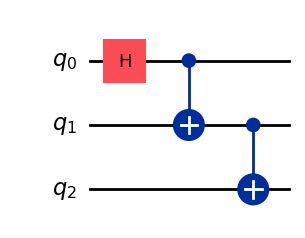

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)

qc.draw(output='mpl')

In [ ]:
# rho = DensityMatrix.from_instruction(qc)

shadows = generate_shadows(qc, backend, n_shots=1024)
rho = build_classical_shadow(shadows, num_qubits=3)

rho

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/6 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/14 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/7 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/7 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/iqm/qiskit_iqm/iqm_provider.py:203: UserWarning: Server default calibration set has changed from 41c2d607-2f5a-464f-a9a6-836b9f15a293 to 3817fc64-5472-4c37-904a-efa44c2ce452. Create a new IQMBackend if you wish to transpile the circuits using the new calibration set.
  warnings.warn(


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/5 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job
ERROR:iqm.iqm_server_client.iqm_server_client:Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

APITimeoutError: The job 019c1842-c910-73f1-a630-05aa51e653ab didn't finish in 900.0 seconds.

In [ ]:
# Estimate the expectation of ZZI
ZZI = np.kron(np.kron(np.array([[1,0],[0,-1]]), np.array([[1,0],[0,-1]])), np.eye(2))
exp_val = estimate_expectation(rho, ZZI)

print("Estimated <ZZI>:", exp_val)

Estimated <ZZI>: 0.9999999999999998


In [ ]:
ME = multipartite_cmi(
    rho,
    subsystems=[[0], [1], [2]]
)

print("Multipartite CMI:", ME)

Multipartite CMI: 3.0


In [ ]:
job = backend.run(transpile(qc, backend=backend), shots=1024)
print(job.result().get_counts())